In [1]:
%matplotlib widget
import numpy as np
from astropy import units as u, constants as c
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import matplotlib
from astropy.convolution import convolve, Gaussian2DKernel
from scipy.optimize import fsolve
from astropy.io import fits
import scipy.interpolate as interp

In [2]:
cnfw = 3.3 # NFW concentration parameter
z = 2.3 # redshift
Rs = 27*u.kpc # = Rvir = 90 kpc
H = cosmo.H(z)

M_h = 1e12*u.M_sun
rho0 = 3*M_h/(4*np.pi*Rs**3) * 0.5
A = 8*np.pi*c.G*rho0*Rs**3/(1*u.kpc)
A = 1.2e7 * u.km**2/u.s**2

bres = 4 # kpc
min_b = 10 # kpc
max_b = 250 # kpc
bvec = np.arange(min_b, max_b, bres)


In [7]:
def heatmap(vival, voffval, a0out, a0in, gout, gin):

    vi = vival * u.km/u.s
    voff = voffval * u.km/u.s
    
    def vels(r):
        vout = np.sqrt(vi**2 + A*(-np.log((Rs.value+1)/Rs.value) + (1/r.value * np.log((Rs+r)/Rs))))
        
        vin = voff + H*r
        return vout , vin

    rmaxrange_out = np.logspace(0,6,1000)
    rmax_out = rmaxrange_out[np.nanargmin(vels(rmaxrange_out*u.kpc)[0])] * u.kpc #300 kpc
    # print(rmax_out)

    rmaxrange_in = np.logspace(0,6,1000)
    rmax_in = rmaxrange_in[np.nanargmin(np.abs(vels(rmaxrange_in*u.kpc)[1]))] * u.kpc
    # rmax_in = 1200*u.kpc #rmaxrange_in[np.nanargmax(vels(rmaxrange_in*u.kpc)[1])] * u.kpc #300 kpc
    # print(rmax_in)

    def alphas(r):
        if r > rmax_out:
            aout=0
        else:
            aout = (a0out * (r/(100*u.kpc))**(-gout)).value
        ain = (a0in * (r/(100*u.kpc))**(-gin)).value
    
        return aout, ain


    taulist_out = []
    taulist_in = []


    for bi, b in enumerate(bvec):
        if b > rmax_out.value:
            for vv in range(-vival,vival):
                taulist_out.append([b,vv, 0])
            continue
        
    
        lmax_out = np.sqrt(rmax_out**2 - (b*u.kpc)**2)
        lmax_in = np.sqrt(rmax_in**2 - (b*u.kpc)**2)
    
        larr_slowl_out = np.linspace(-lmax_out.value, -50, 100)
        nfast_out = int(150 * np.exp(-b/50)) #1500
        larr_fast_out = np.linspace(-50, 50, nfast_out)
        larr_slowr_out = np.linspace(50, lmax_out.value, 100)
        larr_out = np.concatenate([larr_slowl_out, larr_fast_out, larr_slowr_out])
    
        tau_outs = [alphas(np.sqrt((b*u.kpc)**2 + (li*u.kpc)**2))[0] for li in larr_out]


        larr_slowl_in = np.linspace(-lmax_in.value, -50, 100)
        nfast_in = int(150 * np.exp(-b/50)) #1500
        larr_fast_in = np.linspace(-50, 50, nfast_in)
        larr_slowr_in = np.linspace(50, lmax_in.value, 100)
        larr_in = np.concatenate([larr_slowl_in, larr_fast_in, larr_slowr_in])
        tau_ins = [alphas(np.sqrt((b*u.kpc)**2 + (li*u.kpc)**2))[1] for li in larr_in]
        # print(tau_ins)

    
        r_out = np.sqrt(larr_out**2 + b**2)
        r_in = np.sqrt(larr_in**2 + b**2)
        # vout, vin = vels(r*u.kpc)

        vLOS_out = larr_out/r_out*vels(r_out*u.kpc)[0]
        vLOS_in = larr_in/r_in*vels(r_in*u.kpc)[1]
        plt.figure()
        sc = plt.scatter(larr_out, vLOS_out, c=tau_outs)
        sc1 = plt.scatter(larr_in, vLOS_in, c=tau_ins, cmap='inferno')
        plt.xlabel('$\\ell$ (kpc)')
        plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
        plt.colorbar(sc, label = '$\\tau_\\mathrm{out}$')
        plt.colorbar(sc1, label = '$\\tau_\\mathrm{in}$')
        plt.title(f'$b={b}$ kpc')
        plt.axhline(0, c = 'k', alpha = 0.7, lw = 0.7, ls = '--')
        plt.axvline(0, c = 'k', alpha = 0.7, lw = 0.7, ls = '--')
        plt.tight_layout()
        plt.show()
    
        
        
        l_minvout = larr_out[np.argmin(vLOS_out)]
        l_maxvout = larr_out[np.argmax(vLOS_out)]
        maxvout = np.nanmax(vLOS_out.value)
        
        # outflow
        for i in range(int(np.floor(-maxvout)), int(np.ceil(maxvout)), 10):
        
            possible_values = larr_out[(vLOS_out.value > i) & (vLOS_out.value < i+10)]
            l_near = possible_values[(possible_values > l_minvout) & (possible_values < l_maxvout)]
            l_far = possible_values[(possible_values < l_minvout) | (possible_values > l_maxvout)]
    
            tau_near_inds = [np.argwhere(larr_out == ln)[0][0] for ln in l_near]
            tau_out_near = np.array(tau_outs)[tau_near_inds]
    
            
            tau_far_inds = [np.argwhere(larr_out == ln)[0][0] for ln in l_far]
            tau_out_far = np.array(tau_outs)[tau_far_inds]
            tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far) 
            
            taulist_out.append([b, i+5, tau_tot])
    
    
        #inflow
    
        l_minvin = larr_in[np.argmin(vLOS_in)]
        l_maxvin = larr_in[np.argmax(vLOS_in)]
        maxvin = np.nanmax(vLOS_in.value)
        # print(l_minvin, l_maxvin, maxvin)
        
        for i in range(int(np.floor(-maxvin)), int(np.ceil(maxvin)), 10):
        
            possible_values = larr_in[(vLOS_in.value > i) & (vLOS_in.value < i+10)]
            # print(possible_values)
            l_near = possible_values[(possible_values < l_minvin) & (possible_values > l_maxvin)]
            l_far = possible_values[(possible_values > l_minvin) | (possible_values < l_maxvin)]
    
            tau_near_inds = [np.argwhere(larr_in == ln)[0][0] for ln in l_near]
            tau_in_near = np.array(tau_ins)[tau_near_inds]
    
            
            tau_far_inds = [np.argwhere(larr_in == ln)[0][0] for ln in l_far]
            tau_in_far = np.array(tau_ins)[tau_far_inds]
            tau_tot = np.nanmean(tau_in_near) + np.nanmean(tau_in_far) 
            # print(tau_tot)
            
            taulist_in.append([b, i+5, tau_tot])

    
    tauarr_out = np.array(taulist_out)
    tauarr_in = np.array(taulist_in)
    
    # plt.figure()
    # sc = plt.scatter(tauarr_out[:,0], tauarr_out[:,1], c=tauarr_out[:,2]) #/cmap='inferno_r' vmin=2e-2, vmax = 1e-1 norm=matplotlib.colors.LogNorm()
    # plt.colorbar(sc, label = '$\\tau_\\mathrm{out}$')
    
    # tin = plt.scatter(tauarr_in[:,0], tauarr_in[:,1], c=tauarr_in[:,2], cmap='plasma_r') #/cmap='inferno_r' vmin=2e-2, vmax = 1e-1 norm=matplotlib.colors.LogNorm()
    # plt.colorbar(tin, label = '$\\tau_\\mathrm{in}$')
    # plt.xlabel('b (kpc)')
    # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
    # plt.tight_layout()
    # plt.show()
    
    # make map
    
    vres = 100 #50
    vlosr = np.arange(-1000, 1000, vres)
    
    hmap = np.zeros((len(vlosr), len(bvec)))
    
    for bi, b in enumerate(bvec):
        bcut_out = (tauarr_out[:,0] == b)
        bcut_in = (tauarr_in[:,0] == b)
    
        for vind, v in enumerate(vlosr):
            vcut_out = (tauarr_out[:,1] > v) & (tauarr_out[:,1] < v+vres)
            vcut_in = (tauarr_in[:,1] > v) & (tauarr_in[:,1] < v+vres)
            
            tauavg_out = np.nanmean(tauarr_out[:,2][bcut_out & vcut_out])
            if ~np.isfinite(tauavg_out):
                tauavg_out = 0
    
            tauavg_in = np.nanmean(tauarr_in[:,2][bcut_in & vcut_in])
            if ~np.isfinite(tauavg_in):
                tauavg_in = 0

            hmap[vind,bi] = tauavg_out + tauavg_in

    hmap_conv = convolve(hmap, Gaussian2DKernel(3,1.73), boundary = 'extend')

    f = interp.RectBivariateSpline(vlosr, bvec, hmap_conv, kx=3, ky=3)
    newb = np.arange(10,250,5)
    newv = np.arange(-1000, 1000, 100)
    hmap_reshaped = f(newv, newb)
    
    # print(new_im.shape)
    
    # plt.figure()
    # plt.imshow(hmap_reshaped, aspect='auto', origin='lower', extent = [newb.min(), newb.max(), newv.min(), newv.max()])
    # plt.show()
    
    # print(hmap.shape)
    # plt.figure()
    # us = plt.imshow(hmap, origin='lower', extent = (bvec[0], bvec[-1], vlosr[0], vlosr[-1]), 
    #            aspect='auto', cmap='plasma')
    # plt.colorbar(us, label = '$\\tau_\\mathrm{tot}$')
    # plt.xlabel('b (kpc)')
    # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
    # plt.title('Unsmoothed')
    # # plt.xscale('log')
    # plt.show()
    
    # plt.figure()
    # sm = plt.imshow(convolve(hmap, Gaussian2DKernel(3,1.73), boundary = 'extend'), origin='lower', extent = (bvec[0], bvec[-1], vlosr[0], vlosr[-1]), 
    #            aspect='auto', cmap='inferno')
    # plt.colorbar(sm, label = '$\\tau_\\mathrm{tot}$')
    # plt.xlabel('b (kpc)')
    # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
    # plt.title('Smoothed')
    # # plt.xscale('log')
    # plt.show()

    return hmap_reshaped


In [8]:
lya_real = fits.open('lya_conv_240618.fits')[0].data
binterp_vec = np.arange(10,250,5)
vinterp_vec = np.arange(-1000, 1000, 100)

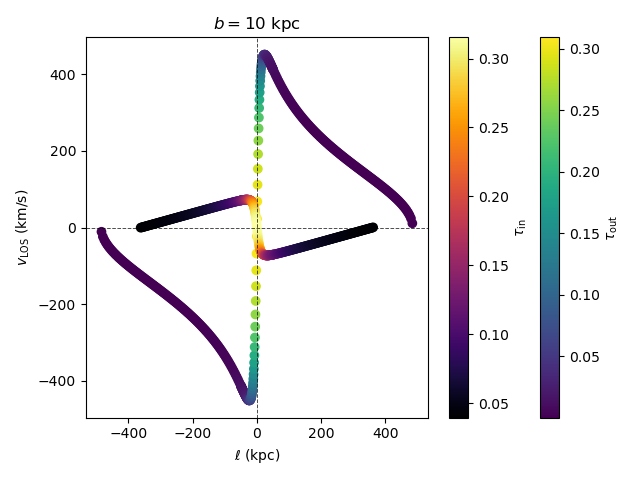

/tmp/ipykernel_3379025/2350041556.py:101: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far)


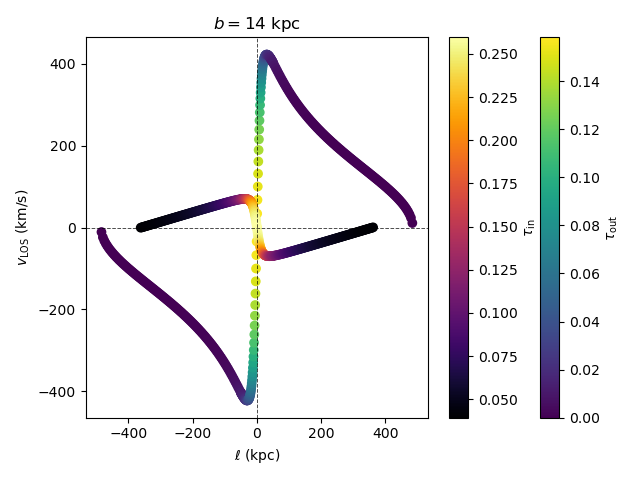

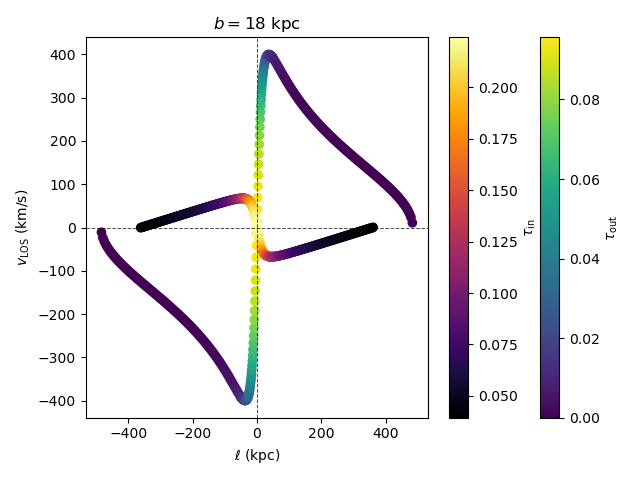

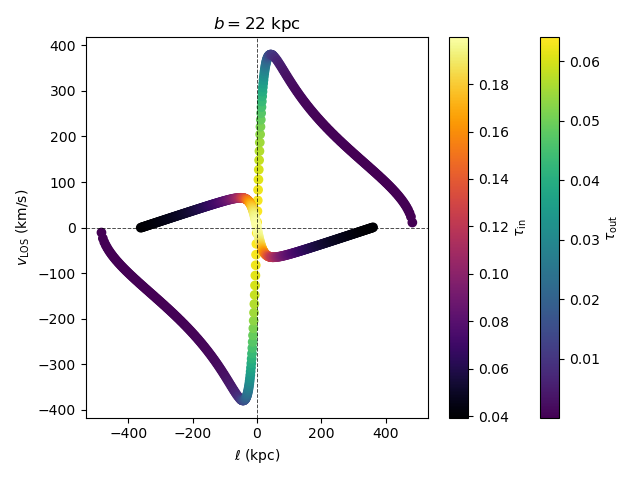

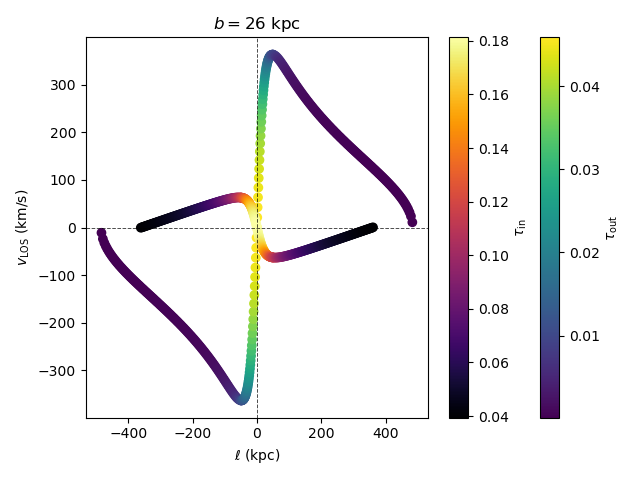

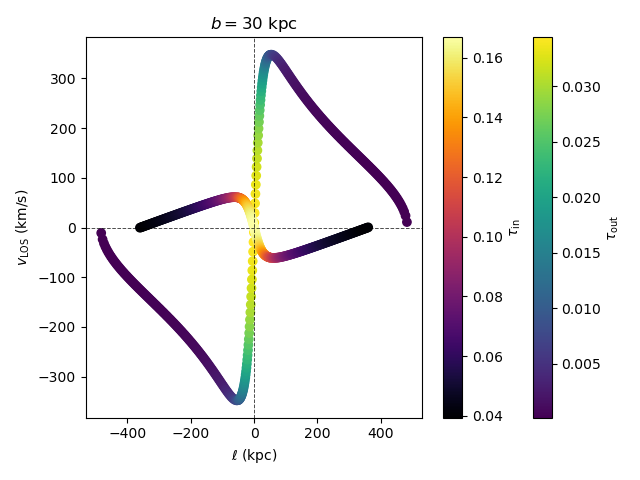

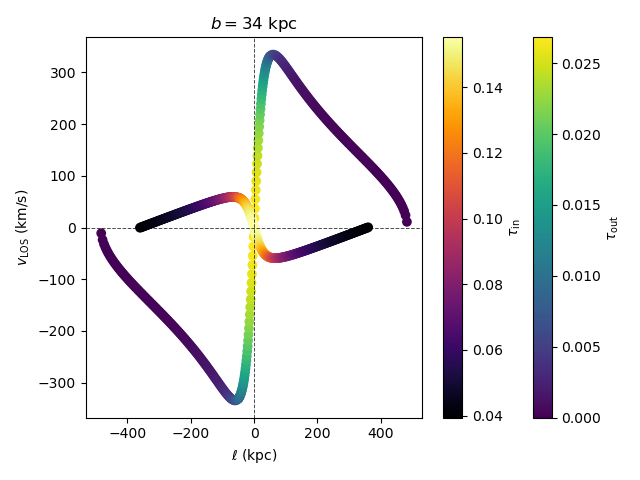

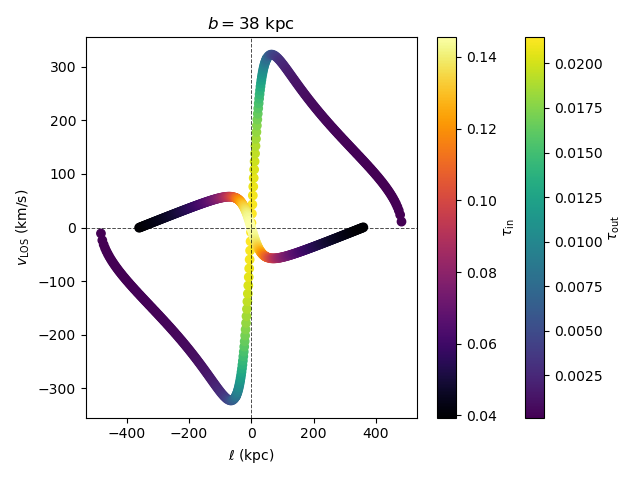

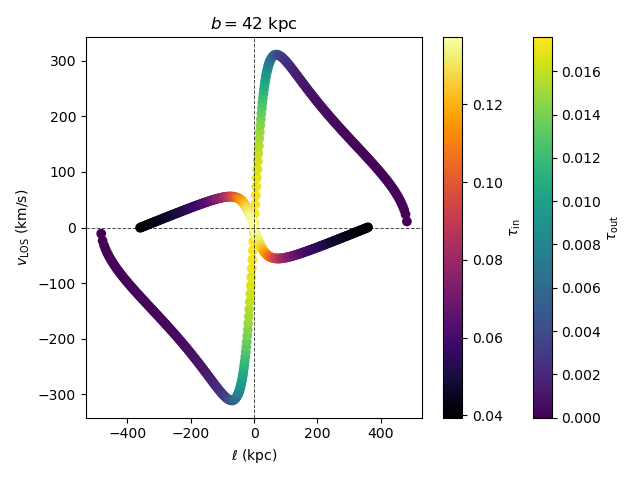

KeyboardInterrupt: 

In [9]:
lya_model = heatmap(603, -84, 0.0031, 0.083, 2, 0.58)


fig, ax = plt.subplots(1,3, figsize = (14,6), sharex=True, sharey=True)
re = ax[0].imshow(lya_real, aspect='auto', origin='lower', extent = [binterp_vec.min(), binterp_vec.max(), vinterp_vec.min(), vinterp_vec.max()])
fig.colorbar(re, ax=ax[0])
ax[0].set_title('Lya Real')

mod = ax[1].imshow(lya_model, aspect='auto', origin='lower', extent = [binterp_vec.min(), binterp_vec.max(), vinterp_vec.min(), vinterp_vec.max()])
fig.colorbar(mod, ax=ax[1])
ax[1].set_title('Lya Model')

diff = ax[2].imshow(lya_real - lya_model, aspect='auto', origin='lower', extent = [binterp_vec.min(), binterp_vec.max(), vinterp_vec.min(), vinterp_vec.max()])
fig.colorbar(diff, ax=ax[2])
ax[2].set_title('Lya Real - Lya Model')
fig.tight_layout()
plt.show()

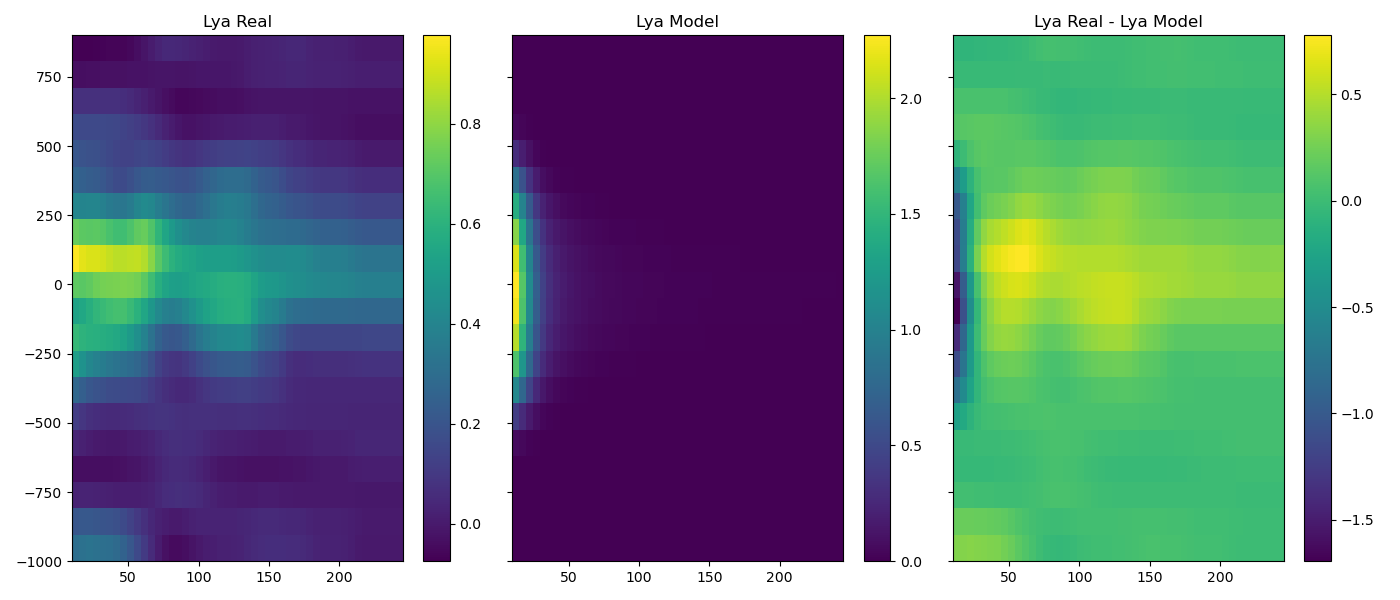

In [36]:
fig, ax = plt.subplots(1,3, figsize = (14,6), sharex=True, sharey=True)
re = ax[0].imshow(lya_real, aspect='auto', origin='lower', extent = [binterp_vec.min(), binterp_vec.max(), vinterp_vec.min(), vinterp_vec.max()])
fig.colorbar(re, ax=ax[0])
ax[0].set_title('Lya Real')

mod = ax[1].imshow(lya_model, aspect='auto', origin='lower', extent = [binterp_vec.min(), binterp_vec.max(), vinterp_vec.min(), vinterp_vec.max()])
fig.colorbar(mod, ax=ax[1])
ax[1].set_title('Lya Model')

diff = ax[2].imshow(lya_real - lya_model, aspect='auto', origin='lower', extent = [binterp_vec.min(), binterp_vec.max(), vinterp_vec.min(), vinterp_vec.max()])
fig.colorbar(diff, ax=ax[2])
ax[2].set_title('Lya Real - Lya Model')
fig.tight_layout()
plt.show()